In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/drive')
import os


/
Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/DFU Dataset/patches.zip" -d "/content/dataset/"

Archive:  /content/drive/MyDrive/DFU Dataset/patches.zip
   creating: /content/dataset/patches/
   creating: /content/dataset/patches/Foot Ulcer/
  inflating: /content/dataset/patches/Foot Ulcer/0001.png  
  inflating: /content/dataset/patches/Foot Ulcer/0002.png  
  inflating: /content/dataset/patches/Foot Ulcer/0003.png  
  inflating: /content/dataset/patches/Foot Ulcer/0004.png  
  inflating: /content/dataset/patches/Foot Ulcer/0005.png  
  inflating: /content/dataset/patches/Foot Ulcer/0006.png  
  inflating: /content/dataset/patches/Foot Ulcer/0007.png  
  inflating: /content/dataset/patches/Foot Ulcer/0008.png  
  inflating: /content/dataset/patches/Foot Ulcer/0009.png  
  inflating: /content/dataset/patches/Foot Ulcer/0010.png  
  inflating: /content/dataset/patches/Foot Ulcer/0025.png  
  inflating: /content/dataset/patches/Foot Ulcer/0030.png  
  inflating: /content/dataset/patches/Foot Ulcer/0033.png  
  inflating: /content/dataset/patches/Foot Ulcer/0046.png  
  inflating: /

In [ ]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Paths and class names
source_folder = "/content/dataset/patches"
train_folder = "/content/dataset/train"
validation_folder = "/content/dataset/validation"
class_names = ["Foot Ulcer", "Normal"]

# Create directories if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(validation_folder, exist_ok=True)

# Train-validation split percentage
train_percentage = 70

# Split dataset into training and validation
for class_name in class_names:
    class_source_folder = os.path.join(source_folder, class_name)
    class_train_folder = os.path.join(train_folder, class_name)
    class_validation_folder = os.path.join(validation_folder, class_name)

    os.makedirs(class_train_folder, exist_ok=True)
    os.makedirs(class_validation_folder, exist_ok=True)

    image_files = [f for f in os.listdir(class_source_folder) if f.endswith(".jpg") or f.endswith(".png")]
    random.shuffle(image_files)

    num_train = int(len(image_files) * (train_percentage / 100))

    for img_file in image_files[:num_train]:
        src_path = os.path.join(class_source_folder, img_file)
        dst_path = os.path.join(class_train_folder, img_file)
        shutil.copy(src_path, dst_path)

    for img_file in image_files[num_train:]:
        src_path = os.path.join(class_source_folder, img_file)
        dst_path = os.path.join(class_validation_folder, img_file)
        shutil.copy(src_path, dst_path)

# Verify split
train_counts = {class_name: len(os.listdir(os.path.join(train_folder, class_name))) for class_name in class_names}
validation_counts = {class_name: len(os.listdir(os.path.join(validation_folder, class_name))) for class_name in class_names}

print("Train Counts:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count} files")

print("\nValidation Counts:")
for class_name, count in validation_counts.items():
    print(f"{class_name}: {count} files")

# Image data generators
batch_size = 16
image_shape = (225, 225)

def add_noise(img):
    VARIABILITY = 50
    deviation = VARIABILITY * random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

# Augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,  # Further reduced
    shear_range=0.05,  # Further reduced
    zoom_range=[0.95, 1.05],  # Further reduced
    horizontal_flip=True,
    brightness_range=[0.95, 1.05],  # Further reduced
    width_shift_range=0.05,  # Further reduced
    height_shift_range=0.05,  # Further reduced
    fill_mode='nearest',
    preprocessing_function=add_noise
)

train_generator = train_datagen.flow_from_directory(
    directory=train_folder,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    directory=validation_folder,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False  # Important: shuffle=False for evaluation consistency
)




Train Counts:
Foot Ulcer: 1225 files
Normal: 887 files

Validation Counts:
Foot Ulcer: 525 files
Normal: 381 files
Found 2112 images belonging to 2 classes.
Found 906 images belonging to 2 classes.


# New Hybrid Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import random

# Base model with EfficientNetB0
base_model = tf.keras.applications.DenseNet121(input_shape=(225, 225, 3), include_top=False, weights='imagenet')

base_model.trainable = False  # Freeze the base model

# Add custom layers on top of the base model
def create_model():
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')  # Adjust the number of classes accordingly
    ])
    return model

model1 = create_model()
model2 = create_model()

# Compile the models
model1.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model2.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint1 = ModelCheckpoint('best_model1.h5', save_best_only=True)
model_checkpoint2 = ModelCheckpoint('best_model2.h5', save_best_only=True)

# Train model 1
history1 = model1.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=40,  # Increase epochs for better training
    callbacks=[early_stopping, model_checkpoint1]
)

# Train model 2
history2 = model2.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=40,  # Increase epochs for better training
    callbacks=[early_stopping, model_checkpoint2]
)

# Fine-tune model 1
base_model.trainable = True
fine_tune_at = 40

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model1.compile(optimizer=optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine1 = model1.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=40,  # More epochs for fine-tuning
    callbacks=[early_stopping, model_checkpoint1]
)

# Fine-tune model 2
model2.compile(optimizer=optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine2 = model2.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=40,  # More epochs for fine-tuning
    callbacks=[early_stopping, model_checkpoint2]
)


KeyboardInterrupt: 

In [ ]:
# Predict the classes on validation data
val_predictions1 = model1.predict(validation_generator)
val_predictions2 = model2.predict(validation_generator)

# Average the predictions
final_predictions = (val_predictions1 + val_predictions2) / 2
val_pred_classes = np.argmax(final_predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(true_classes, val_pred_classes, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, val_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Plotting training & validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'] + history_fine1.history['accuracy'], label='Training Accuracy Model 1')
plt.plot(history1.history['val_accuracy'] + history_fine1.history['val_accuracy'], label='Validation Accuracy Model 1')
plt.plot(history2.history['accuracy'] + history_fine2.history['accuracy'], label='Training Accuracy Model 2')
plt.plot(history2.history['val_accuracy'] + history_fine2.history['val_accuracy'], label='Validation Accuracy Model 2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plotting training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'] + history_fine1.history['loss'], label='Training Loss Model 1')
plt.plot(history1.history['val_loss'] + history_fine1.history['val_loss'], label='Validation Loss Model 1')
plt.plot(history2.history['loss'] + history_fine2.history['loss'], label='Training Loss Model 2')
plt.plot(history2.history['val_loss'] + history_fine2.history['val_loss'], label='Validation Loss Model 2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# AlexNet

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization_5 (Bat  (None, 54, 54, 96)        384       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 26, 26, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 batch_normalization_6 (Bat  (None, 26, 26, 256)       1024      
 chNormalization)                                                
                                                      

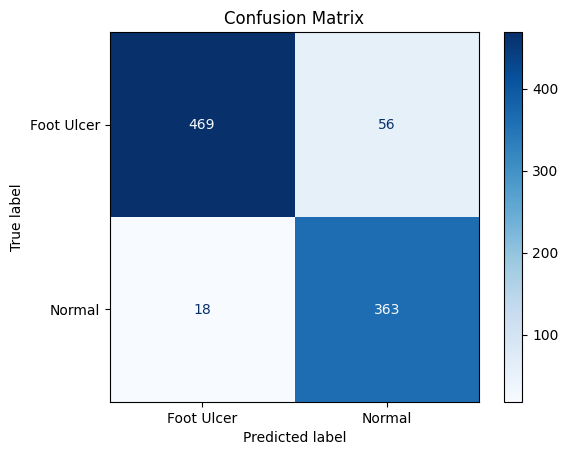

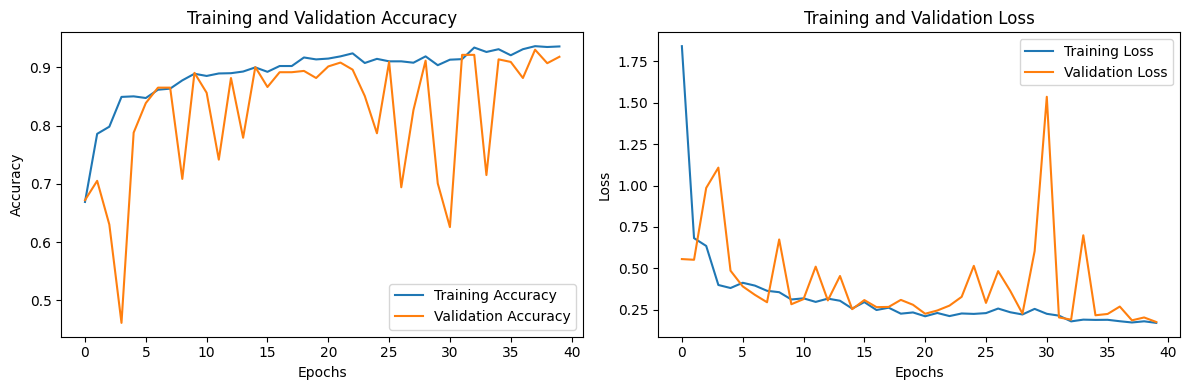

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
import tensorflow as tf

# Define the model
model = Sequential([
    Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation="relu", input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same"),
    BatchNormalization(),
    Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    Flatten(),
    Dense(4096, activation="relu"),
    Dropout(0.5),
    Dense(4096, activation="relu"),
    Dropout(0.5),
    Dense(2, activation="softmax")  # Change number of classes to 2 (Foot Ulcer, Normal)
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])

# Print the model summary
model.summary()

# Define the training and validation steps
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

# Evaluate and generate reports
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Predict the classes on validation data
val_predictions = model.predict(validation_generator)
val_pred_classes = np.argmax(val_predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Classification report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("Classification Report:")
print(classification_report(true_classes, val_pred_classes, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, val_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Plotting training & validation accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plotting training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# DenseNet121 - All okay

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 7300418 (27.85 MB)
Trainable params: 262914

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


132/132 [==============================] - 81s 453ms/step - loss: 0.3387 - accuracy: 0.8594 - val_loss: 0.2218 - val_accuracy: 0.9040
Epoch 2/20
132/132 [==============================] - 54s 407ms/step - loss: 0.2347 - accuracy: 0.8991 - val_loss: 0.2106 - val_accuracy: 0.9205
Epoch 3/20
132/132 [==============================] - 52s 397ms/step - loss: 0.2192 - accuracy: 0.9176 - val_loss: 0.2598 - val_accuracy: 0.8863
Epoch 4/20
132/132 [==============================] - 51s 383ms/step - loss: 0.2055 - accuracy: 0.9214 - val_loss: 0.1876 - val_accuracy: 0.9183
Epoch 5/20
132/132 [==============================] - 53s 405ms/step - loss: 0.1793 - accuracy: 0.9266 - val_loss: 0.1785 - val_accuracy: 0.9349
Epoch 6/20
132/132 [==============================] - 52s 396ms/step - loss: 0.1756 - accuracy: 0.9313 - val_loss: 0.1736 - val_accuracy: 0.9426
Epoch 7/20
132/132 [==============================] - 53s 403ms/step - loss: 0.1841 - accuracy: 0.9261 - val_loss: 0.1788 - val_accuracy: 0.9

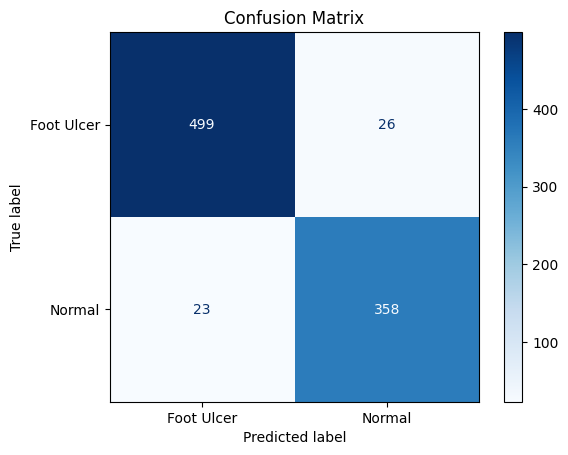

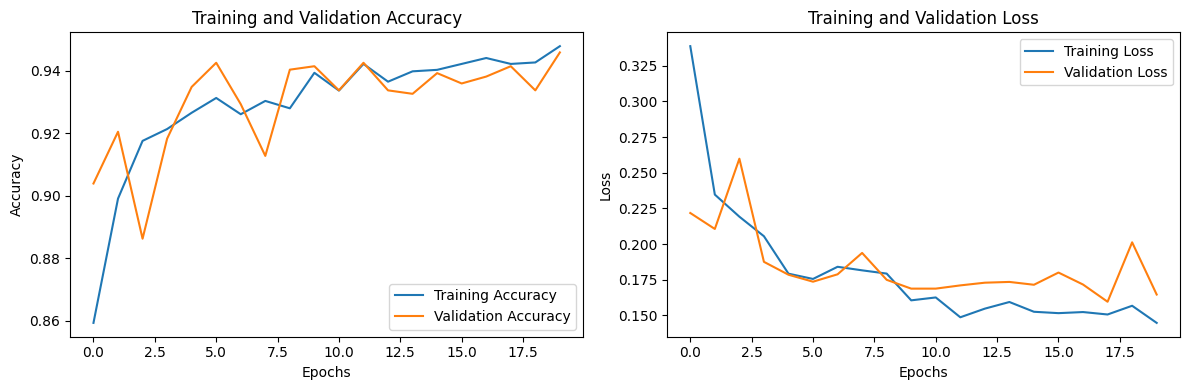

In [ ]:
# Define the model
densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(225, 225, 3))
densenet.trainable = False  # Freeze the base model

model = Sequential([
    densenet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint]
)

# Evaluate and generate reports
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Predict the classes on validation data
val_predictions = model.predict(validation_generator)
val_pred_classes = np.argmax(val_predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(true_classes, val_pred_classes, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, val_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Plotting training & validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plotting training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# Inception V3 - All Okay

87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 22327842 (85.17 MB)
Trainable params: 525

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


132/132 [==============================] - 60s 396ms/step - loss: 0.4562 - accuracy: 0.8333 - val_loss: 0.2523 - val_accuracy: 0.8985
Epoch 2/10
132/132 [==============================] - 53s 398ms/step - loss: 0.2755 - accuracy: 0.8887 - val_loss: 0.2486 - val_accuracy: 0.9051
Epoch 3/10
132/132 [==============================] - 59s 446ms/step - loss: 0.2635 - accuracy: 0.8845 - val_loss: 0.2491 - val_accuracy: 0.8974
Epoch 4/10
132/132 [==============================] - 51s 389ms/step - loss: 0.2572 - accuracy: 0.8958 - val_loss: 0.2393 - val_accuracy: 0.9161
Epoch 5/10
132/132 [==============================] - 50s 379ms/step - loss: 0.2314 - accuracy: 0.9138 - val_loss: 0.2259 - val_accuracy: 0.9117
Epoch 6/10
132/132 [==============================] - 54s 406ms/step - loss: 0.2276 - accuracy: 0.9152 - val_loss: 0.2395 - val_accuracy: 0.9007
Epoch 7/10
132/132 [==============================] - 59s 450ms/step - loss: 0.2067 - accuracy: 0.9171 - val_loss: 0.2344 - val_accuracy: 0.9

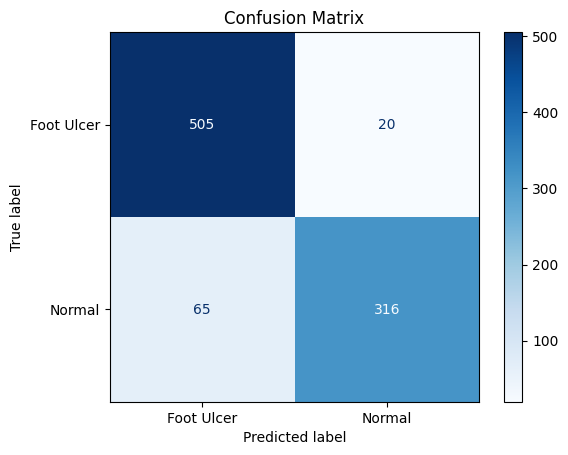

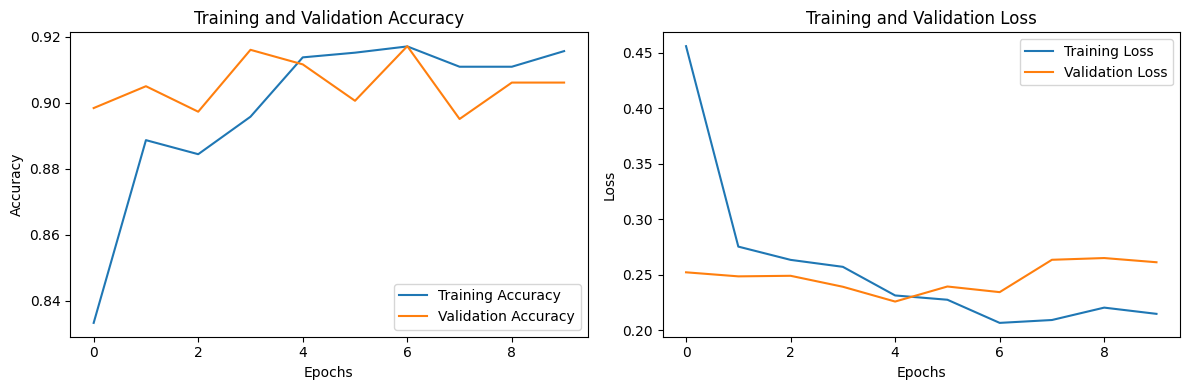

In [ ]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Define the model
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(225, 225, 3))
inception.trainable = False  # Freeze the base model

model = Sequential([
    inception,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint]
)

# Evaluate and generate reports
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Predict the classes on validation data
val_predictions = model.predict(validation_generator)
val_pred_classes = np.argmax(val_predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(true_classes, val_pred_classes, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, val_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Plotting training & validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plotting training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# Xception

83683744/83683744 [==============================] - 2s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_5  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 256)               524544    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 2)                 514       
                                                                 
Total params: 21386538 (81.58 MB)
Trainable params: 525

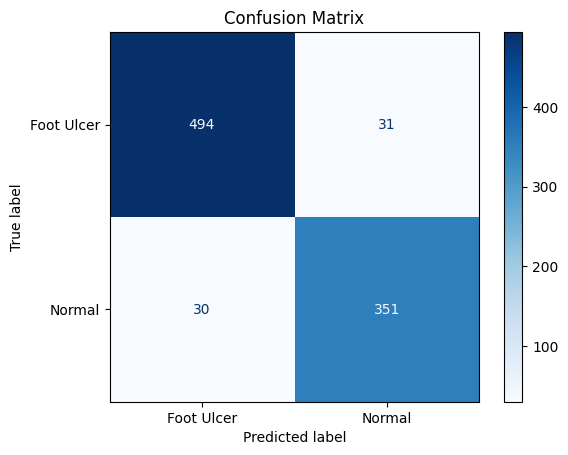

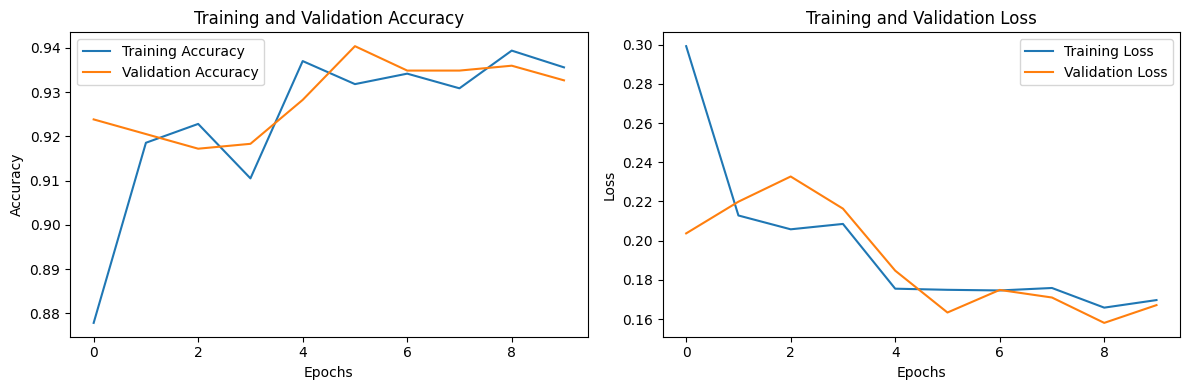

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model
xception = Xception(weights='imagenet', include_top=False, input_shape=(225, 225, 3))
xception.trainable = False  # Freeze the base model

model = Sequential([
    xception,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint]
)

# Evaluate and generate reports
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Predict the classes on validation data
val_predictions = model.predict(validation_generator)
val_pred_classes = np.argmax(val_predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(true_classes, val_pred_classes, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, val_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Plotting training & validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plotting training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


# NASNetMobile - All Okay

19993432/19993432 [==============================] - 0s 0us/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 global_average_pooling2d_7  (None, 1056)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 256)               270592    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 2)                 514       
                                                                 
Total params: 4540822 (17.32 MB)
Trainable params: 2711

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


132/132 [==============================] - 135s 905ms/step - loss: 0.2960 - accuracy: 0.8755 - val_loss: 0.2093 - val_accuracy: 0.9216
Epoch 2/10
132/132 [==============================] - 54s 407ms/step - loss: 0.2116 - accuracy: 0.9162 - val_loss: 0.2285 - val_accuracy: 0.9150
Epoch 3/10
132/132 [==============================] - 52s 394ms/step - loss: 0.1957 - accuracy: 0.9238 - val_loss: 0.1835 - val_accuracy: 0.9283
Epoch 4/10
132/132 [==============================] - 53s 399ms/step - loss: 0.1910 - accuracy: 0.9313 - val_loss: 0.2038 - val_accuracy: 0.9327
Epoch 5/10
132/132 [==============================] - 51s 384ms/step - loss: 0.1652 - accuracy: 0.9361 - val_loss: 0.1688 - val_accuracy: 0.9349
Epoch 6/10
132/132 [==============================] - 53s 405ms/step - loss: 0.1688 - accuracy: 0.9366 - val_loss: 0.2042 - val_accuracy: 0.9283
Epoch 7/10
132/132 [==============================] - 54s 406ms/step - loss: 0.1597 - accuracy: 0.9380 - val_loss: 0.1678 - val_accuracy: 0.

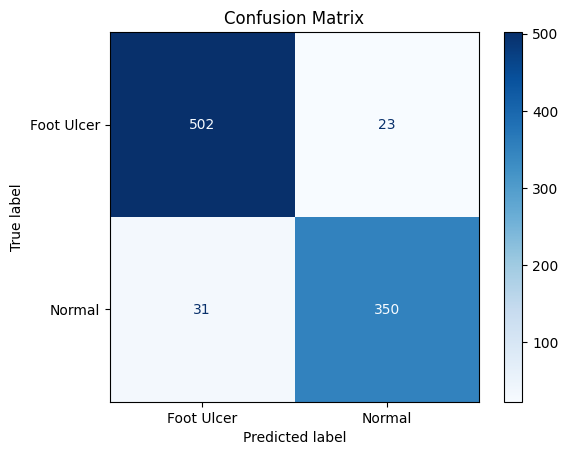

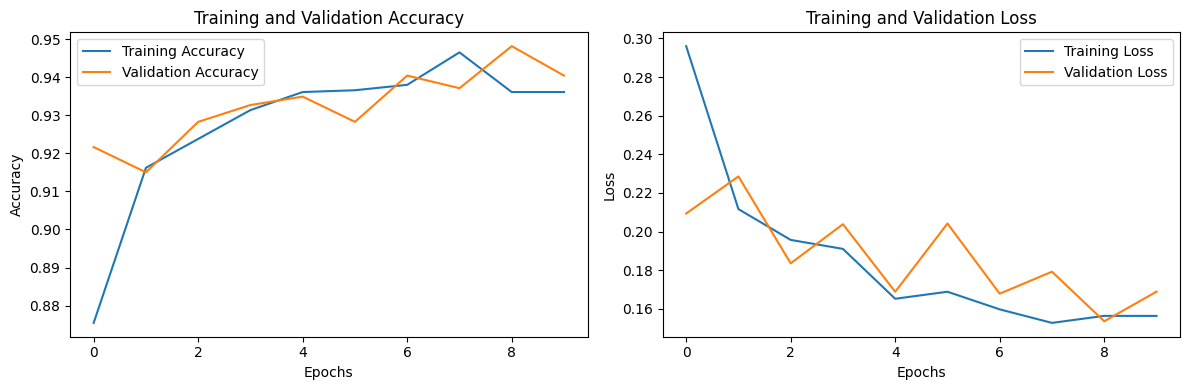

In [ ]:
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model
nasnet_mobile = NASNetMobile(weights='imagenet', include_top=False, input_shape=(225, 225, 3))
nasnet_mobile.trainable = False  # Freeze the base model

model = Sequential([
    nasnet_mobile,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint]
)

# Evaluate and generate reports
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Predict the classes on validation data
val_predictions = model.predict(validation_generator)
val_pred_classes = np.argmax(val_predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(true_classes, val_pred_classes, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, val_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Plotting training & validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plotting training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


# Hybrid Model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 225, 225, 3)]        0         []                            
                                                                                                  
 densenet121 (Functional)    (None, 7, 7, 1024)           7037504   ['input_11[0][0]']            
                                                                                                  
 NASNet (Functional)         (None, 7, 7, 1056)           4269716   ['input_11[0][0]']            
                                                                                                  
 global_average_pooling2d_8  (None, 1024)                 0         ['densenet121[0][0]']         
  (GlobalAveragePooling2D)                                                                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


132/132 [==============================] - 88s 484ms/step - loss: 0.3495 - accuracy: 0.8712 - val_loss: 0.1921 - val_accuracy: 0.9349
Epoch 2/20
132/132 [==============================] - 61s 461ms/step - loss: 0.1927 - accuracy: 0.9238 - val_loss: 0.1756 - val_accuracy: 0.9393
Epoch 3/20
132/132 [==============================] - 57s 431ms/step - loss: 0.1972 - accuracy: 0.9238 - val_loss: 0.1859 - val_accuracy: 0.9249
Epoch 4/20
132/132 [==============================] - 60s 451ms/step - loss: 0.1620 - accuracy: 0.9342 - val_loss: 0.1579 - val_accuracy: 0.9481
Epoch 5/20
132/132 [==============================] - 56s 423ms/step - loss: 0.1542 - accuracy: 0.9408 - val_loss: 0.1559 - val_accuracy: 0.9470
Epoch 6/20
132/132 [==============================] - 58s 441ms/step - loss: 0.1622 - accuracy: 0.9399 - val_loss: 0.1362 - val_accuracy: 0.9614
Epoch 7/20
132/132 [==============================] - 59s 449ms/step - loss: 0.1675 - accuracy: 0.9384 - val_loss: 0.1563 - val_accuracy: 0.9

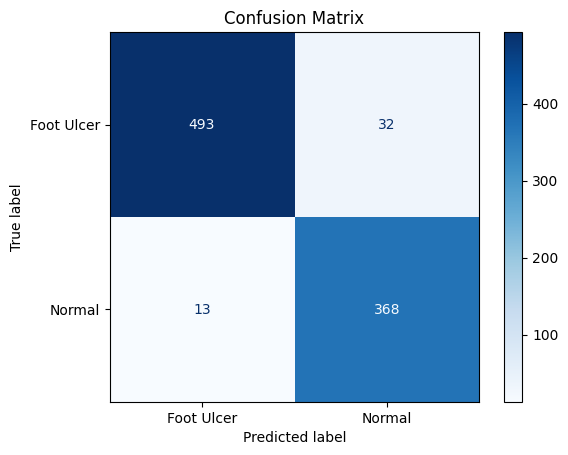

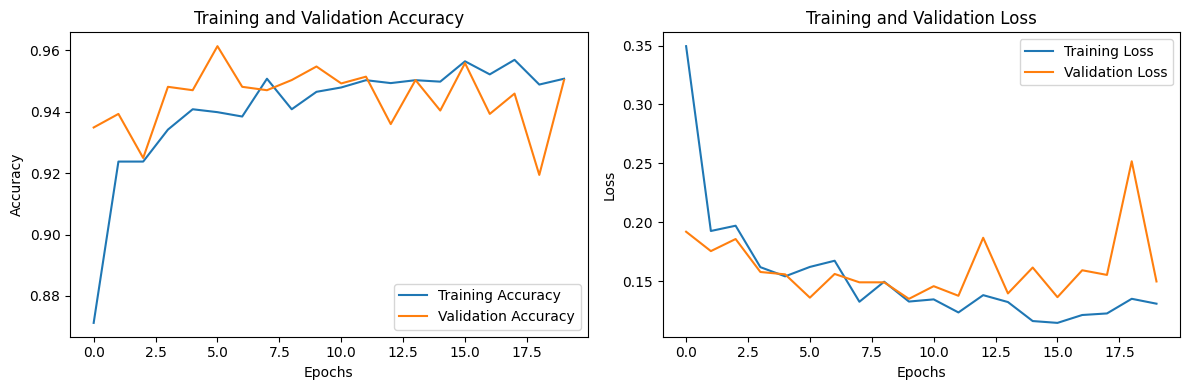

In [ ]:
from tensorflow.keras.applications import DenseNet121, NASNetMobile
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

# Load DenseNet121
densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(225, 225, 3))
densenet.trainable = False  # Freeze the base model

# Load NASNetMobile
nasnet = NASNetMobile(weights='imagenet', include_top=False, input_shape=(225, 225, 3))
nasnet.trainable = False  # Freeze the base model

# Create the input layer
input_layer = layers.Input(shape=(225, 225, 3))

# Get features from DenseNet121
densenet_features = densenet(input_layer)
densenet_features = layers.GlobalAveragePooling2D()(densenet_features)

# Get features from NASNetMobile
nasnet_features = nasnet(input_layer)
nasnet_features = layers.GlobalAveragePooling2D()(nasnet_features)

# Concatenate features
concatenated_features = layers.concatenate([densenet_features, nasnet_features])

# Add custom layers on top of concatenated features
x = layers.Dense(512, activation='relu')(concatenated_features)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(train_generator.num_classes, activation='softmax')(x)

# Define the model
hybrid_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
hybrid_model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy'])
hybrid_model.summary()

# Define callbacks
checkpoint = ModelCheckpoint('best_hybrid_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = hybrid_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint]
)

# Evaluate and generate reports
val_loss, val_accuracy = hybrid_model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Predict the classes on validation data
val_predictions = hybrid_model.predict(validation_generator)
val_pred_classes = np.argmax(val_predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(true_classes, val_pred_classes, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, val_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Plotting training & validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plotting training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


# MobileNetV3

In [ ]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.layers import Dense, Dropout

# Model name for reference
model_name = 'MobileNetV3Small'

# Define the base model
base_model = tf.keras.applications.MobileNetV3Small(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Add custom layers on top of the base model
x = base_model.output
x = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.45, seed=123)(x)
output = Dense(class_count, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint]
)

# Evaluate and generate reports
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Predict the classes on validation data
val_predictions = model.predict(validation_generator)
val_pred_classes = np.argmax(val_predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(true_classes, val_pred_classes, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, val_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Plotting training & validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plotting training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

NameError: name 'img_shape' is not defined

# VGG16 - All Okay

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 2)                 514       
                                                                 
Total params: 14846530 (56.64 MB)
Trainable params: 131

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


132/132 [==============================] - 53s 404ms/step - loss: 0.4671 - accuracy: 0.7888 - val_loss: 0.4452 - val_accuracy: 0.7903
Epoch 3/10
132/132 [==============================] - 52s 395ms/step - loss: 0.4412 - accuracy: 0.7912 - val_loss: 0.4286 - val_accuracy: 0.7881
Epoch 4/10
132/132 [==============================] - 51s 385ms/step - loss: 0.4026 - accuracy: 0.8215 - val_loss: 0.3929 - val_accuracy: 0.8234
Epoch 5/10
132/132 [==============================] - 51s 384ms/step - loss: 0.3807 - accuracy: 0.8324 - val_loss: 0.3821 - val_accuracy: 0.8124
Epoch 6/10
132/132 [==============================] - 52s 393ms/step - loss: 0.3824 - accuracy: 0.8314 - val_loss: 0.4302 - val_accuracy: 0.8046
Epoch 7/10
132/132 [==============================] - 52s 392ms/step - loss: 0.3648 - accuracy: 0.8348 - val_loss: 0.3533 - val_accuracy: 0.8344
Epoch 8/10
132/132 [==============================] - 51s 384ms/step - loss: 0.3683 - accuracy: 0.8376 - val_loss: 0.3548 - val_accuracy: 0.8

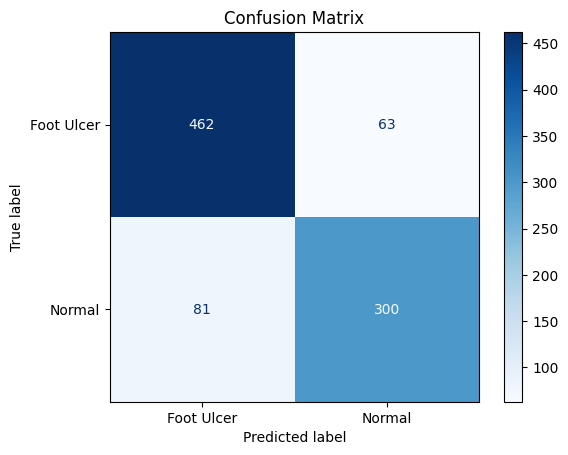

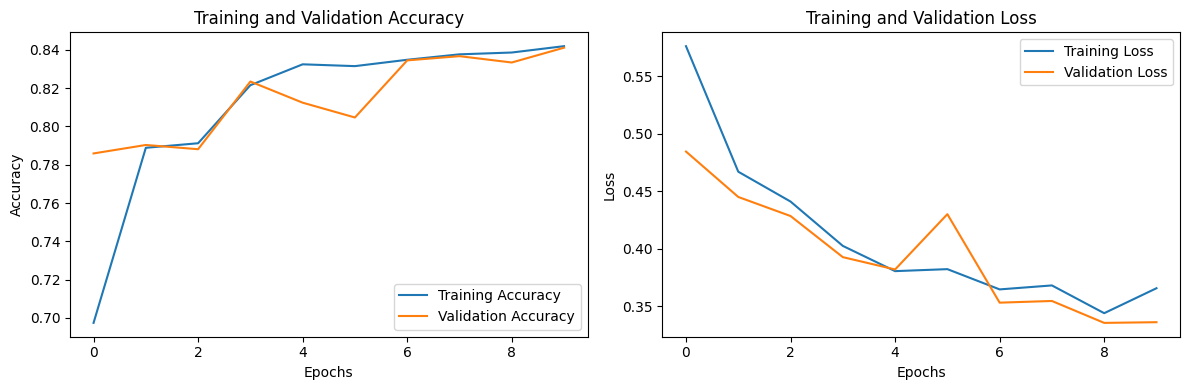

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Define the model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16.trainable = False  # Freeze the base model

model = Sequential([
    vgg16,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint]
)

# Evaluate and generate reports
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Predict the classes on validation data
val_predictions = model.predict(validation_generator)
val_pred_classes = np.argmax(val_predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(true_classes, val_pred_classes, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, val_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Plotting training & validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plotting training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# Vision Transformers (ViT)

In [ ]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 22.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.3 MB/s eta 0:00:00


In [ ]:
pip install tensorflow-hub


In [ ]:
# Model
model = create_model('vit_base_patch16_224', num_classes=10, pretrained=True).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training
num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0.0  # Variable to track the best validation accuracy

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100 * correct / total
    train_loss /= len(train_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_loss /= len(test_loader)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.2f}%')

    # Save the model if the current validation accuracy is the best so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'vit_model_best.pth')

# Plotting accuracy and loss in a single plot
plt.figure(figsize=(10, 6))

# Plot training and validation accuracy
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')

# Plot training and validation loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='green')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red')

plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'device' is not defined

# Swin Transformer

In [ ]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import timm
from timm import create_model

# Define the Swin Transformer model using timm
swin_model = create_model('swin_base_patch4_window12_384', pretrained=True, num_classes=train_generator.num_classes)

# Compile the model
swin_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
swin_model.summary()

# Define callbacks
checkpoint = ModelCheckpoint('best_swin_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = swin_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint]
)

# Evaluate and generate reports
val_loss, val_accuracy = swin_model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Predict the classes on validation data
val_predictions = swin_model.predict(validation_generator)
val_pred_classes = np.argmax(val_predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(true_classes, val_pred_classes, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, val_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Plotting training & validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plotting training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


model.safetensors:   0%|          | 0.00/365M [00:00<?, ?B/s]

TypeError: compile() got an unexpected keyword argument 'loss'

# RegNet

In [ ]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 13.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 223, 223, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

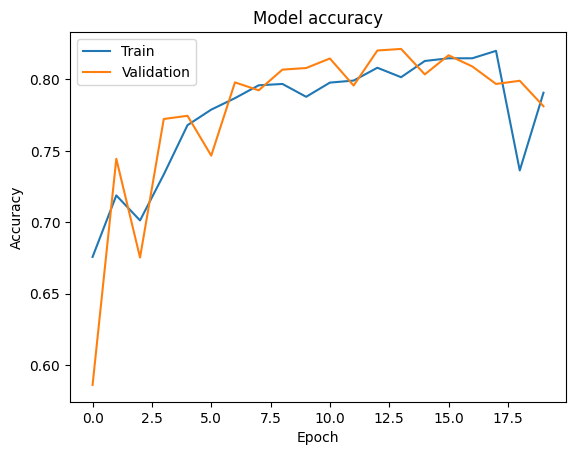

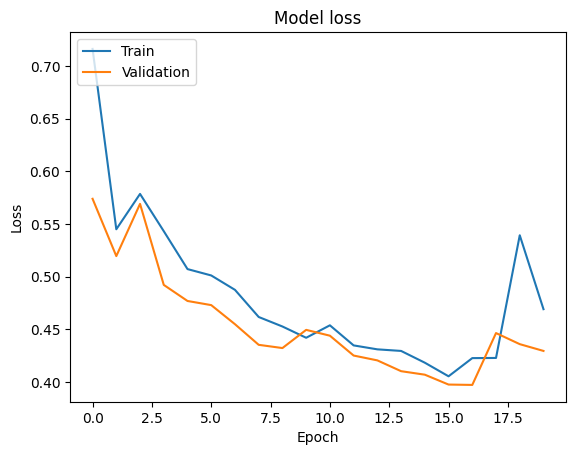

57/57 [==============================] - 2s 30ms/step
Confusion Matrix
[[440  85]
 [113 268]]
Classification Report
              precision    recall  f1-score   support

  Foot Ulcer       0.80      0.84      0.82       525
      Normal       0.76      0.70      0.73       381

    accuracy                           0.78       906
   macro avg       0.78      0.77      0.77       906
weighted avg       0.78      0.78      0.78       906



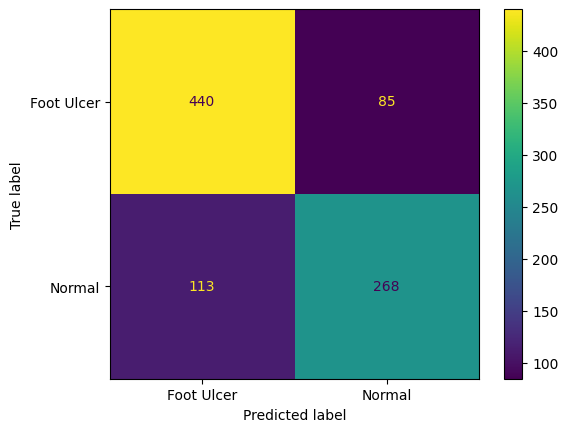

In [ ]:
import timm
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow as tf

# Model definition
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(225, 225, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Training the model
epochs = 20

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    verbose=1
)

# Plotting training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model
model.evaluate(validation_generator)

# Confusion matrix
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

# Classification report
print('Classification Report')
target_names = list(validation_generator.class_indices.keys())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

# Plot confusion matrix
cm = confusion_matrix(validation_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
plt.show()